# Imports

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import calendar
from scipy.stats import skew
from xgboost import plot_importance
from matplotlib.ticker import FuncFormatter

# SQL - Data Cleaning

In [2]:
# loading sql extension
%load_ext sql
%sql sqlite:///movies.db
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

In [3]:
%%sql
DROP TABLE
IF EXISTS rtm_clean;
DROP TABLE
IF EXISTS movie_clean;
DROP TABLE
IF EXISTS combined_final;

 * sqlite:///movies.db
Done.
Done.
Done.


[]

### Table Visualizing 

In [4]:
%%sql 
-- Displaying all table names --
SELECT name 
FROM sqlite_master 
WHERE type='table';

 * sqlite:///movies.db
Done.


name
rtm_raw
movie_raw
combined_raw


In [5]:
%%sql 
-- Displaying the first 5 rows from rtm_raw --
SELECT * 
FROM rtm_raw 
LIMIT 5;

 * sqlite:///movies.db
Done.


movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,audience_count
Percy Jackson & the Olympians: The Lightning Thief,A teenager discovers he's the descendant of a Greek god and sets out on an adventure to settle an on-going battle between the gods.,"Though it may seem like just another Harry Potter knockoff, Percy Jackson benefits from a strong supporting cast, a speedy plot, and plenty of fun with Greek mythology.",PG,"Action & Adventure, Comedy, Drama, Science Fiction & Fantasy",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Daddario, Jake Abel, Sean Bean, Pierce Brosnan, Steve Coogan, Rosario Dawson, Melina Kanakaredes, Catherine Keener, Kevin Mckidd, Joe Pantoliano, Uma Thurman, Ray Winstone, Julian Richings, Bonita Friedericy, Annie Ilonzeh, Tania Saulnier, Marie Avgeropoulos, Luisa D'Oliveira, Christie Laing, Marielle Jaffe, Elisa King, Chrystal Tisiga, Alexis Knapp, Charlie Gallant, Chelan Simmons, Andrea Brooks, Natassia Malthe, Max Van Ville, Serinda Swan, Dimitri Lekkos, Ona Grauer, Stefanie von Pfetten, Conrad Coates, Erica Cerra, Dylan Neal, Luke Camilleri, Holly Hougham, Ina Geraldine, Raquel Riskin, Yusleidis Oquendo, Janine Edwards, Valerie Tian, Violet Columbus, Sarah Smyth, Merritt Patterson, Julie Luck, Andrea Day, John Stewart, Suzanne Ristic, Deejay Jackson, Matthew Garrick, Stan Carp, Suzanna Ristic, Richard Harmon, Maria Olsen, Robin Lemon, Doyle Devereux, Tom Pickett, VJ Delos-Reyes, Tim Aas, Keith Dallas, Spencer Atkinson, Maya Washington, Loyd Bateman, Victor Ayala, Zane Holtz, Eli Zagoudakis, Matt Reimer, Rob Hayter, Lloyd Bateman, Shawn Beaton, Jarod Joseph, Reilly Dolman, Paul Cummings, Julie Brar, Dejan Loyola, Damian Arman, Mario Casoria, Dorla Bell, Carolyn Adair (II), Jade Pawluk, G. Patrick Currie, Darian Arman, Mariela Zapata, David L. Smith",2010-02-12,2010-06-29,83,20th Century Fox,Rotten,49,144,53,254287
Please Give,"Kate has a lot on her mind. There's the ethics problem of buying furniture on the cheap at estate sales and marking it up at her trendy Manhattan store. And how much markup can she get away with? There's the materialism problem of not wanting her teenage daughter to want the expensive things that Kate wants. There's the marriage problem of sharing a partnership in parenting, business and life with her husband Alex but sensing doubt nibbling at the foundations. And, there's Kate's free-floating 21st century malaise -- the problem of how to live well and be a good person when poverty, homelessness, and sadness are always right outside the door. Plus, there's the neighbors: cranky, elderly Andra and the two granddaughters who look after her.","Nicole Holofcener's newest might seem slight in places, but its rendering of complex characters in a conflicted economic landscape is varied, natural, and touching all the same.",R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, Rebecca Hall, Sarah Steele, Ann Morgan Guilbert, Kevin Corrigan, Lois Smith",2010-04-30,2010-10-19,90,Sony Pictures Classics,Certified Fresh,86,140,64,11567
10,"Blake Edwards' 10 stars Dudley Moore as George, a Mancini-type songwriter. Approaching middle age, George feels as if life is passing him by, especially his sex life. Despite the presence of longtime lady friend Sam (Julie Andrews) in his life, he becomes obsessed from afar with Jenny (Bo Derek), who is engaged to be married. Following her to Mexico without her knowledge, George arranges a meeting with Jenny by saving the life of her fiancé, David (Sam Jones). Once he has made her acquaintance, George suddenly finds himself faced with the realities of embarking on such an affair. Beyond renewing the popularity of Maurice Ravel's ""Bolero"" and turning Bo Derek into a star, upon its release, 10 was one of the most financially success

In [6]:
%%sql 
-- Displaying first 5 rows from movie_raw--
SELECT * 
FROM movie_raw 
LIMIT 5;

 * sqlite:///movies.db
Done.


Movie,Director,Running time,Actor 1,Actor 2,Actor 3,Genre,Budget,Box Office,Actors Box Office %,Director Box Office %,Earnings,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,Release year,IMDb score
13 Hours,Michael Bay,144,Toby Stephens,James Badge Dale,David Costabile,Action,50000000,69400000,50.0,69.23,19400000,0,0,2016,7.4
16 Blocks,Richard Donner,102,Bruce Willis,David Zayas,Sasha Roiz,Action,52000000,65000000,33.33,50.0,13000000,0,0,2006,6.6
17 Again,Burr Steers,102,Matthew Perry,Hunter Parrish,Thomas Lennon,Comedy,20000000,139000000,44.44,25.0,119000000,0,0,2009,6.4
1982,Tommy Oliver,90,Bokeem Woodbine,Ruby Dee,Quinton Aaron,Drama,1000000,2000000,50.0,100.0,1000000,0,0,2013,7.1
2 Fast 2 Furious,John Singleton,107,Paul Walker,Cole Hauser,Mo Gallini,Action,76000000,236000000,75.0,42.85,160000000,0,0,2003,5.9


### Text Cleaning

In [7]:
# define a clean text function
def clean_text(s):
    try:
        # empty string handling
        if s is None:
            return None
        
        # Force to string and lowercase
        s = str(s).lower()
        
        # Remove unwanted character string values
        for ch in [' and ', '&', ':', '(', ')', '[', ']', ',', ' ']:
            s = s.replace(ch, '')
        
        return s
   # excepting handling if an error occurs  
    except Exception as e:
        # display what values are having issues
        print("Problem value:", repr(s), "type:", type(s), "error:", repr(e))
        # return a null value if error occurs
        return None  # fallback so it doesn't crash the whole query

In [8]:
# Using sqlite3 to connect to the database 
conn = sqlite3.connect("movies.db")

# Register the function
conn.create_function("clean_text", 1, clean_text)

# create cursor object
cur = conn.cursor()

# drop the table so code block can be re-run
cur.execute("""DROP TABLE IF EXISTS rtm_clean;""")

# create the new table
cur.execute("""
    CREATE TABLE rtm_clean AS
    SELECT
        rtm_raw.*,
        clean_text(movie_title) AS title_key,
        clean_text(directors)   AS director_key
    FROM rtm_raw
    WHERE movie_title IS NOT NULL
      AND directors   IS NOT NULL;
""")

# remove unneccesary columns
cur.execute("ALTER TABLE rtm_clean DROP COLUMN cast;")
cur.execute("ALTER TABLE rtm_clean DROP COLUMN movie_info;")
cur.execute("ALTER TABLE rtm_clean DROP COLUMN critics_consensus;")

# commit the function
conn.commit()
# close connection
conn.close()

In [9]:
%%sql 
-- checking new table --
SELECT * 
FROM rtm_clean 
LIMIT 5;

 * sqlite:///movies.db
Done.


movie_title,rating,genre,directors,writers,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,audience_count,title_key,director_key
Percy Jackson & the Olympians: The Lightning Thief,PG,"Action & Adventure, Comedy, Drama, Science Fiction & Fantasy",Chris Columbus,Craig Titley,2010-02-12,2010-06-29,83,20th Century Fox,Rotten,49,144,53,254287,percyjacksontheolympiansthelightningthief,chriscolumbus
Please Give,R,Comedy,Nicole Holofcener,Nicole Holofcener,2010-04-30,2010-10-19,90,Sony Pictures Classics,Certified Fresh,86,140,64,11567,pleasegive,nicoleholofcener
10,R,"Comedy, Romance",Blake Edwards,Blake Edwards,1979-10-05,1997-08-27,118,Waner Bros.,Fresh,68,22,53,14670,10,blakeedwards
12 Angry Men (Twelve Angry Men),NR,"Classics, Drama",Sidney Lumet,Reginald Rose,1957-04-13,2001-03-06,95,Criterion Collection,Certified Fresh,100,51,97,105000,12angrymentwelveangrymen,sidneylumet
"20,000 Leagues Under The Sea",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,1954-01-01,2003-05-20,127,Disney,Fresh,89,27,74,68860,20000leaguesunderthesea,richardfleischer


In [10]:
%%sql

-- drop table so code block can be re-run--
DROP TABLE IF EXISTS movie_clean;

-- create new cleaned table --
CREATE TABLE movie_clean AS
SELECT
    movie_raw.*,

    -- replace all unneccessary text values to create title key --
    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
        LOWER(Movie),
        ' and ', ''), '&', ''), ':', ''), 
        '(', ''), ')', ''), '[', ''), ']', ''), ',', ''), ' ', ''
    ) AS title_key,

    -- replace all unneccessary text values to create director key--
    REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(REPLACE(
        LOWER(Director),
        ' and ', ''), '&', ''), ':', ''), 
        '(', ''), ')', ''), '[', ''), ']', ''), ',', ''), ' ', ''
    ) AS director_key

FROM movie_raw
WHERE Movie    IS NOT NULL -- ensure that null values are not included as keys --
  AND Director IS NOT NULL;

 * sqlite:///movies.db
Done.
Done.


[]

In [11]:
%sql SELECT * FROM movie_clean LIMIT 5;

 * sqlite:///movies.db
Done.


Movie,Director,Running time,Actor 1,Actor 2,Actor 3,Genre,Budget,Box Office,Actors Box Office %,Director Box Office %,Earnings,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,Release year,IMDb score,title_key,director_key
13 Hours,Michael Bay,144,Toby Stephens,James Badge Dale,David Costabile,Action,50000000,69400000,50.0,69.23,19400000,0,0,2016,7.4,13hours,michaelbay
16 Blocks,Richard Donner,102,Bruce Willis,David Zayas,Sasha Roiz,Action,52000000,65000000,33.33,50.0,13000000,0,0,2006,6.6,16blocks,richarddonner
17 Again,Burr Steers,102,Matthew Perry,Hunter Parrish,Thomas Lennon,Comedy,20000000,139000000,44.44,25.0,119000000,0,0,2009,6.4,17again,burrsteers
1982,Tommy Oliver,90,Bokeem Woodbine,Ruby Dee,Quinton Aaron,Drama,1000000,2000000,50.0,100.0,1000000,0,0,2013,7.1,1982,tommyoliver
2 Fast 2 Furious,John Singleton,107,Paul Walker,Cole Hauser,Mo Gallini,Action,76000000,236000000,75.0,42.85,160000000,0,0,2003,5.9,2fast2furious,johnsingleton


### Creating Combined Table

In [12]:
%%sql
-- create a combined table with both the rtm_clean table and the movie_clean table --
CREATE TABLE combined_raw AS
SELECT
    r.*,
    m.*
FROM rtm_clean AS r
INNER JOIN movie_clean AS m
    ON r.title_key = m.title_key -- join on the keys --
   AND r.director_key = m.director_key;

 * sqlite:///movies.db
(sqlite3.OperationalError) table combined_raw already exists
[SQL: -- create a combined table with both the rtm_clean table and the movie_clean table --
CREATE TABLE combined_raw AS
SELECT
    r.*,
    m.*
FROM rtm_clean AS r
INNER JOIN movie_clean AS m
    ON r.title_key = m.title_key -- join on the keys --
   AND r.director_key = m.director_key;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


In [13]:
%%sql 
-- check the number of data points before cleaning --
SELECT COUNT(*) 
AS merged_rows 
FROM combined_raw;

 * sqlite:///movies.db
Done.


merged_rows
3021


In [14]:
%%sql
-- display the first 5 rows of the dataframe--
SELECT * 
FROM combined_raw 
LIMIT 5;

 * sqlite:///movies.db
Done.


movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,audience_count,title_key,director_key,Movie,Director,Running time,Actor 1,Actor 2,Actor 3,Genre:1,Budget,Box Office,Actors Box Office %,Director Box Office %,Earnings,Oscar and Golden Globes nominations,Oscar and Golden Globes awards,Release year,IMDb score,title_key:1,director_key:1
Percy Jackson & the Olympians: The Lightning Thief,A teenager discovers he's the descendant of a Greek god and sets out on an adventure to settle an on-going battle between the gods.,"Though it may seem like just another Harry Potter knockoff, Percy Jackson benefits from a strong supporting cast, a speedy plot, and plenty of fun with Greek mythology.",PG,"Action & Adventure, Comedy, Drama, Science Fiction & Fantasy",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Daddario, Jake Abel, Sean Bean, Pierce Brosnan, Steve Coogan, Rosario Dawson, Melina Kanakaredes, Catherine Keener, Kevin Mckidd, Joe Pantoliano, Uma Thurman, Ray Winstone, Julian Richings, Bonita Friedericy, Annie Ilonzeh, Tania Saulnier, Marie Avgeropoulos, Luisa D'Oliveira, Christie Laing, Marielle Jaffe, Elisa King, Chrystal Tisiga, Alexis Knapp, Charlie Gallant, Chelan Simmons, Andrea Brooks, Natassia Malthe, Max Van Ville, Serinda Swan, Dimitri Lekkos, Ona Grauer, Stefanie von Pfetten, Conrad Coates, Erica Cerra, Dylan Neal, Luke Camilleri, Holly Hougham, Ina Geraldine, Raquel Riskin, Yusleidis Oquendo, Janine Edwards, Valerie Tian, Violet Columbus, Sarah Smyth, Merritt Patterson, Julie Luck, Andrea Day, John Stewart, Suzanne Ristic, Deejay Jackson, Matthew Garrick, Stan Carp, Suzanna Ristic, Richard Harmon, Maria Olsen, Robin Lemon, Doyle Devereux, Tom Pickett, VJ Delos-Reyes, Tim Aas, Keith Dallas, Spencer Atkinson, Maya Washington, Loyd Bateman, Victor Ayala, Zane Holtz, Eli Zagoudakis, Matt Reimer, Rob Hayter, Lloyd Bateman, Shawn Beaton, Jarod Joseph, Reilly Dolman, Paul Cummings, Julie Brar, Dejan Loyola, Damian Arman, Mario Casoria, Dorla Bell, Carolyn Adair (II), Jade Pawluk, G. Patrick Currie, Darian Arman, Mariela Zapata, David L. Smith",2010-02-12,2010-06-29,83,20th Century Fox,Rotten,49,144,53,254287,percyjacksontheolympiansthelightningthief,chriscolumbus,Percy Jackson & the Olympians: The Lightning Thief,Chris Columbus,118,Logan Lerman,Rosario Dawson,Steve Coogan,Adventure,95000000,226000000,58.33,72.72,131000000,0,0,2010,5.9,percyjacksontheolympiansthelightningthief,chriscolumbus
"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,000 Leagues Under the Sea represented the studio's costliest and most elaborate American-filmed effort to date. Kirk Douglas plays a trouble-shooting 19th century seaman, trying to discover why so many whaling ships have been disappearing of late. Teaming with scientist Paul Lukas and diver Peter Lorre, Douglas sets sail to investigate--and is promptly captured by the megalomaniac Captain Nemo (James Mason), who skippers a lavish, scientifically advanced submarine. The film's special effects, including a giant squid, were impressive enough in 1954 to win an Academy Award. ~ Hal Erickson, Rovi","One of Disney's finest live-action adventures, 20,000 Leagues Under the Sea brings Jules Verne's classic sci-fi tale to vivid life, and features an awesome giant squid.",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter Lorre, Robert J. Wilke, Carleton Young, Bob Wilke, Ted de Corsia, Percy Helton, Ted Cooper, Eddie Marr, Fred Graham, Esmeralda, J.M. Kerrigan, Harry Harvey, Herb Vigran",1954-01-01,2003-05-20,127,Disney,Fresh,89,27,74,68860,20000leaguesunderthesea,richardfleischer,20000 Leagues Under the Sea,Richard Fleischer,127,James Mason,Robert J. Wilke,Paul Lukas,Adventure,5000000,285000000,100.0,80.0,280000000,3,1,195

### Final SQL Table

In [15]:
%%sql
-- create a new dataframe with only the necessary columns and cleaned names --
CREATE TABLE combined_final AS
SELECT
    rating,
    studio_name,
    tomatometer_count,
    audience_count,
    director_key,
    [Running time],
    [Genre:1] AS Genre,
    Budget,
    [Box Office],
    [Actors Box Office %],
    [Director Box Office %],
    Earnings,
    [Release year],
    [IMDb score],
    tomatometer_rating,
    audience_rating,
    in_theaters_date, 
    critics_consensus,
    [Actor 1],
    [Actor 2],
    [Actor 3]
FROM combined_raw;

 * sqlite:///movies.db
Done.


[]

# Python Data Cleaning/Engineering

### Data Gathering into DataFrame

In [16]:
# reconnect to the dataframe
conn = sqlite3.connect('movies.db')

In [17]:
# check the raw dataframes columns
df_temp = pd.read_sql_query("SELECT * FROM combined_raw LIMIT 1;", conn)
df_temp.columns

Index(['movie_title', 'movie_info', 'critics_consensus', 'rating', 'genre',
       'directors', 'writers', 'cast', 'in_theaters_date', 'on_streaming_date',
       'runtime_in_minutes', 'studio_name', 'tomatometer_status',
       'tomatometer_rating', 'tomatometer_count', 'audience_rating',
       'audience_count', 'title_key', 'director_key', 'Movie', 'Director',
       'Running time', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre:1', 'Budget',
       'Box Office', 'Actors Box Office %', 'Director Box Office %',
       'Earnings', 'Oscar and Golden Globes nominations',
       'Oscar and Golden Globes awards', 'Release year', 'IMDb score',
       'title_key:1', 'director_key:1'],
      dtype='object')

In [18]:
conn = sqlite3.connect('movies.db')
conn.text_factory = lambda b: b.decode('latin-1') #ignores error when decoding

# ensure that the new dataframe contains only neccessary columns
df = pd.read_sql_query("SELECT * FROM combined_final;", conn)
df.columns

Index(['rating', 'studio_name', 'tomatometer_count', 'audience_count',
       'director_key', 'Running time', 'Genre', 'Budget', 'Box Office',
       'Actors Box Office %', 'Director Box Office %', 'Earnings',
       'Release year', 'IMDb score', 'tomatometer_rating', 'audience_rating',
       'in_theaters_date', 'critics_consensus', 'Actor 1', 'Actor 2',
       'Actor 3'],
      dtype='object')

In [19]:
# visualize final dataframe
df.head()

,rating,studio_name,tomatometer_count,audience_count,director_key,Running time,Genre,Budget,Box Office,Actors Box Office %,...,Earnings,Release year,IMDb score,tomatometer_rating,audience_rating,in_theaters_date,critics_consensus,Actor 1,Actor 2,Actor 3
0,PG,20th Century Fox,144,254287,chriscolumbus,118,Adventure,95000000,226000000,58.33,...,131000000,2010,5.9,49,53,2010-02-12,Though it may seem like just another Harry Pot...,Logan Lerman,Rosario Dawson,Steve Coogan
1,G,Disney,27,68860,richardfleischer,127,Adventure,5000000,285000000,100.0,...,280000000,1954,7.2,89,74,1954-01-01,"One of Disney's finest live-action adventures,...",James Mason,Robert J. Wilke,Paul Lukas
2,PG,Fine Line Features,24,1931,marymcguckian,120,Drama,24000000,12000000,56.66,...,-12000000,2004,5.1,4,35,2005-06-10,Despite an all-star cast and some impressive v...,Robert De Niro,F. Murray Abraham,Geraldine Chaplin
3,R,New Line Cinema,130,135373,waynekramer,122,Action,17000000,19000000,69.84,...,2000000,2006,7.4,41,79,2006-02-24,This film runs with frenetic energy punctuated...,Paul Walker,Chazz Palminteri,Ivana Milicevic
4,PG-13,Sony Pictures,83,279966,kurtwimmer,94,Action,30000000,31000000,33.33,...,1000000,2006,4.4,8,30,2006-03-03,An incomprehensible and forgettable sci-fi thr...,Milla Jovovich,Cameron Bright,Nick Chinlund


## Final Data Cleaning in Python

In [20]:
data_clean = df

In [21]:
# check the columns
data_clean.columns

Index(['rating', 'studio_name', 'tomatometer_count', 'audience_count',
       'director_key', 'Running time', 'Genre', 'Budget', 'Box Office',
       'Actors Box Office %', 'Director Box Office %', 'Earnings',
       'Release year', 'IMDb score', 'tomatometer_rating', 'audience_rating',
       'in_theaters_date', 'critics_consensus', 'Actor 1', 'Actor 2',
       'Actor 3'],
      dtype='object')

In [22]:
# check the counts by Genre to ensure enough data
data_clean.groupby('Genre')['rating'].count()

Genre
Action         742
Adventure      190
Animation       66
Biography      191
Comedy         786
Crime          227
Documentary     17
Drama          472
Horror         162
Mystery         18
Romance          3
Sci-Fi          50
Thriller        87
Western         10
Name: rating, dtype: int64

#### Converting necessary columns to numeric

In [23]:
# ensuring that all necessary columns are numeric
num_cols = ['Running time', 'Actors Box Office %', 'Director Box Office %', 
            'Budget', 'IMDb score', 'tomatometer_rating']

# transforming columns to numeric
for column in num_cols:
    data_clean[column] = pd.to_numeric(data_clean[column])

#### Fixing missing audience rating values

In [24]:
# checking for empty values in dependent variable
data_clean[data_clean['audience_rating'] == '']

,rating,studio_name,tomatometer_count,audience_count,director_key,Running time,Genre,Budget,Box Office,Actors Box Office %,...,Earnings,Release year,IMDb score,tomatometer_rating,audience_rating,in_theaters_date,critics_consensus,Actor 1,Actor 2,Actor 3
97,PG,Touchstone Pictures,41,,ronhoward,111,Comedy,8000000,69000000,91.67,...,61000000,1984,6.2,90,,1984-03-09,"A perfectly light, warmly funny romantic comed...",Tom Hanks,Howard Morris,Patrick Cronin
1014,PG-13,Warner Bros. Pictures,169,,jaychandrasekhar,107,Action,50000000,111000000,66.67,...,61000000,2005,5.1,14,,2005-08-05,"A dumb, goofy, and vacuous adaptation of a TV ...",Alice Greczyn,Jessica Simpson,Michael Weston
2769,PG,Time Changer Productions,9,,richchristiano,95,Drama,825000,1000000,33.33,...,175000,2002,5.6,22,,2002-10-25,,Gavin MacLeod,D. David Morin,Hal Linden


In [25]:
# replacing empty audience ratings with median
median_audience_rating = pd.to_numeric(data_clean[data_clean['audience_rating'] != '']['audience_rating']).median()

data_clean['audience_rating'] = data_clean['audience_rating'].replace('', median_audience_rating)

# converting column to numeric
data_clean['audience_rating'] = pd.to_numeric(data_clean['audience_rating'])

In [26]:
data_clean.describe()

,Running time,Budget,Actors Box Office %,Director Box Office %,IMDb score,tomatometer_rating,audience_rating
count,3021.000000,3.021000e+03,3.021000e+03,3021.000000,3021.000000,3021.000000,3021.000000
mean,111.476663,3.768899e+07,3.926220e+09,53.225746,6.489308,54.658060,61.790467
std,22.076025,4.160991e+07,1.542206e+11,33.737305,1.040899,27.577319,19.467993
min,65.000000,1.500000e+04,0.000000e+00,0.000000,1.600000,0.000000,11.000000
25%,97.000000,1.000000e+07,3.333000e+01,33.330000,5.900000,31.000000,47.000000
50%,107.000000,2.500000e+07,5.714000e+01,50.000000,6.600000,56.000000,63.000000
75%,121.000000,5.000000e+07,8.333000e+01,80.000000,7.200000,80.000000,78.000000
max,325.000000,3.900000e+08,6.805556e+12,100.000000,9.300000,100.000000,98.000000


## Data Engineering 

#### Creating a season column

In [27]:
# converting string to datatime 
data_clean['in_theaters_date'] = pd.to_datetime(data_clean['in_theaters_date'])

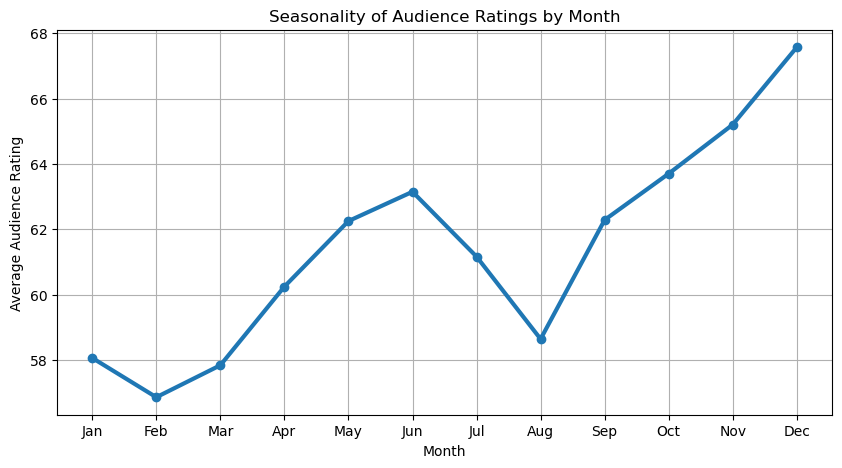

In [28]:
# taking a closer look at the ratings by months 

# create a month column for grouping
data_clean['month'] = data_clean['in_theaters_date'].dt.month


# create a dataframe of the average audience ratings by month
monthly_seasonality = data_clean.groupby('month')['audience_rating'].mean()

# plotting specification
plt.figure(figsize=(10,5))
plt.plot(monthly_seasonality.index, monthly_seasonality, marker='o', linewidth=3)

# change x-labels to month names
plt.xticks(
    ticks=range(1, 13),
    labels=[calendar.month_abbr[m] for m in range(1, 13)]
)

plt.title("Seasonality of Audience Ratings by Month")
plt.xlabel("Month")
plt.ylabel("Average Audience Rating")
plt.grid(True)
plt.show()

**Findings**: There are clear differences in audience ratings by month for the data. As the end of the year approaches the movies that come to theaters seem to be higher rated, this could be due to studios strategically releasing stronger titles during this time due to peoples willingness to come to the theaters. Additionally movies that come out at the end of spring and heading into the summer show higher performance as well, this is what is typically considered 'blockbuster' time for studios as theaters benefit from increased leasure time and higher consumer interest. The other months are 'dump months' where weaker titles are released. 

**Capturing Details**: In order to capture this in our models we are going to implement a season dummy variable.

In [29]:
# converting in theaters date to season

# converting string to datetime object
release_dates = data_clean['in_theaters_date']

# extracting the month
release_months = release_dates.dt.month

# function to convert month values to seasons
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# add release season column
data_clean['season'] = release_months.apply(month_to_season)

In [30]:
# re-cleaning dataset
data_clean = data_clean.drop('month', axis=1)

#### Adjusting the budget column for the skewness (log budget)

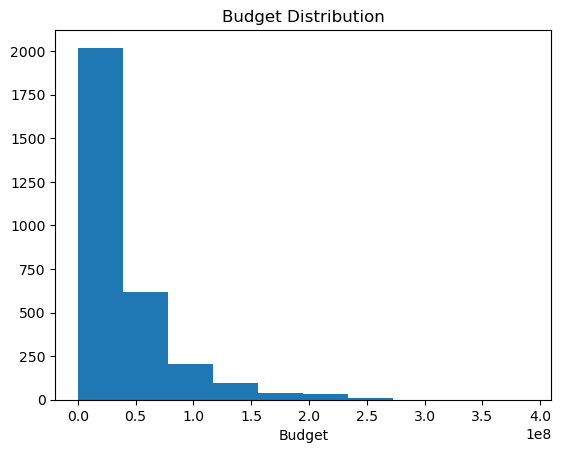

In [31]:
# visualize the distribution of budget 
plt.hist(data_clean['Budget'])
plt.title('Budget Distribution')
plt.xlabel('Budget')
plt.show()

**Findings**: The Budget distrubution is highly skewed, when using machine learning models it is important to adjust for the skew of the data. Therefore implementing a log tranformation will help to make te model less biased.

In [32]:
# adding a log budget column to deal with heavy skewness
data_clean['log budget'] = np.log(data_clean['Budget'])

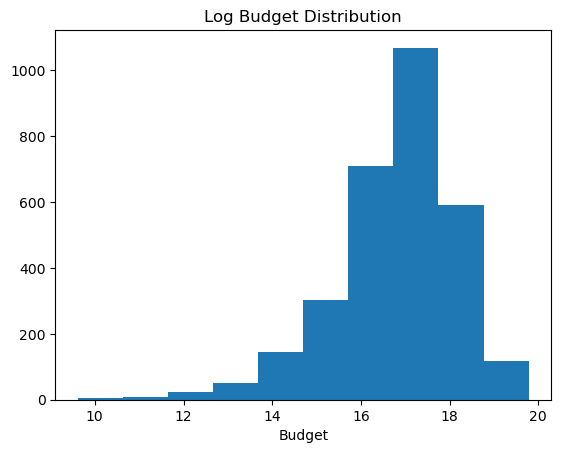

In [33]:
plt.hist(data_clean['log budget'])
plt.title('Log Budget Distribution')
plt.xlabel('Budget')
plt.show()

In [34]:
print("Original budget skew:", skew(data_clean['Budget'].dropna()))
print("Log budget skew:", skew(data_clean['log budget'].dropna()))

Original budget skew: 2.2383938065007536
Log budget skew: -1.0786847225401521


**Findings**: Based on the above graph and skew values we can see that the budget variable is less skewed. This will reduce the influene of large-budget outliers.

#### Running time log adjustment

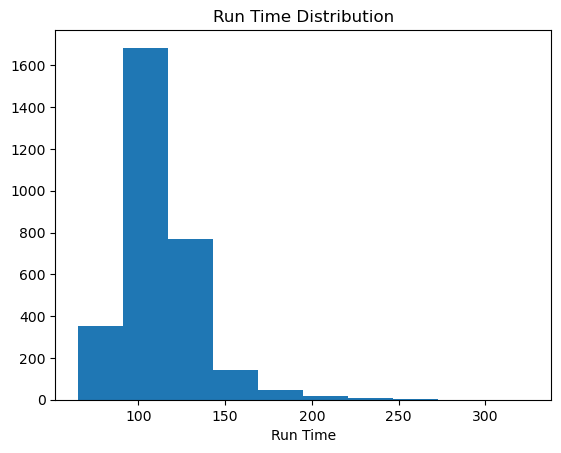

In [35]:
# visualize the distribution of run time
plt.hist(data_clean['Running time'])
plt.title('Run Time Distribution')
plt.xlabel('Run Time')
plt.show()

**Finding**: There is a heavy right skew to the run time data that can be adjusted through a log transformation

In [36]:
# adding a log run time column to deal with heavy skewness
data_clean['log run time'] = np.log(data_clean['Running time'])

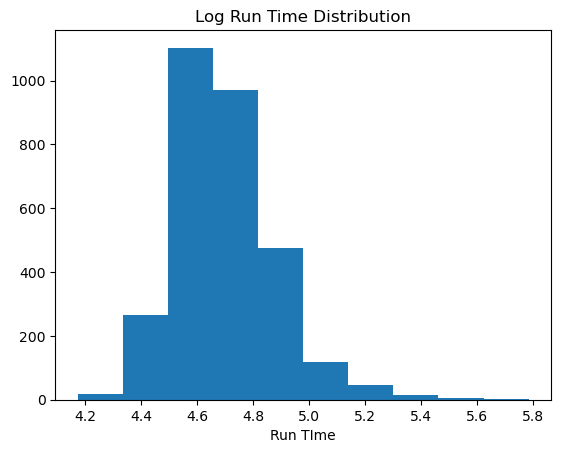

In [37]:
plt.hist(data_clean['log run time'])
plt.title('Log Run Time Distribution')
plt.xlabel('Run TIme')
plt.show()

#### Creating dummy variables

In [38]:
# narrowing down studio dummy variables

# displaying the top most common studios
data_clean['studio_name'].value_counts().head(10)

studio_name
Warner Bros. Pictures               234
Universal Pictures                  223
20th Century Fox                    206
Paramount Pictures                  191
Sony Pictures                       110
Columbia Pictures                    91
New Line Cinema                      86
Miramax Films                        66
Sony Pictures Home Entertainment     61
MGM                                  56
Name: count, dtype: int64

In [39]:
# create an array of the top studio names
top_studio_names = data_clean['studio_name'].value_counts().head(10).index

data_clean['studio_name'] = data_clean['studio_name'].apply(lambda x: x if x in top_studio_names else 'Other')

In [40]:
# adding dummy variables 
dummy_cols = ['studio_name', 'rating', 'season', 'Genre']

data_clean = pd.get_dummies(data_clean, columns=dummy_cols, drop_first=True)

data_clean.head()

,tomatometer_count,audience_count,director_key,Running time,Budget,Box Office,Actors Box Office %,Director Box Office %,Earnings,Release year,...,Genre_Comedy,Genre_Crime,Genre_Documentary,Genre_Drama,Genre_Horror,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_Western
0,144,254287,chriscolumbus,118,95000000,226000000,58.33,72.72,131000000,2010,...,False,False,False,False,False,False,False,False,False,False
1,27,68860,richardfleischer,127,5000000,285000000,100.00,80.00,280000000,1954,...,False,False,False,False,False,False,False,False,False,False
2,24,1931,marymcguckian,120,24000000,12000000,56.66,0.00,-12000000,2004,...,False,False,False,True,False,False,False,False,False,False
3,130,135373,waynekramer,122,17000000,19000000,69.84,50.00,2000000,2006,...,False,False,False,False,False,False,False,False,False,False
4,83,279966,kurtwimmer,94,30000000,31000000,33.33,0.00,1000000,2006,...,False,False,False,False,False,False,False,False,False,False


#### Text analysis for sentiment score

In [41]:
# developing a text consensus score

# download VADER lexicon for text sentiment score (-1 to 1)
nltk.download('vader_lexicon')

# initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# create a sentiment column
data_clean['sentiment_score'] = data_clean['critics_consensus'].apply(lambda x: sia.polarity_scores(x)['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tcame\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


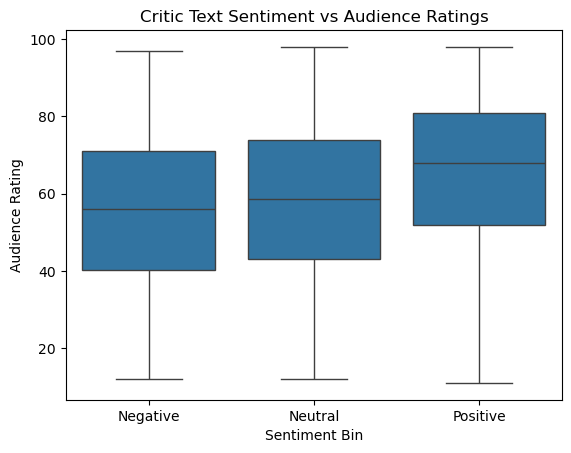

In [42]:
# creating sentiment bins to visualize how well the sentiment score captures the audience rating 
data_clean['sentiment_bin'] = pd.cut(data_clean['sentiment_score'],
                                     bins=[-1, -0.2, 0.2, 1],
                                     labels=['Negative','Neutral','Positive'])

# boxplot of the bins
sns.boxplot(x='sentiment_bin', y='audience_rating', data=data_clean)
plt.xlabel('Sentiment Bin')
plt.ylabel('Audience Rating')
plt.title('Critic Text Sentiment vs Audience Ratings')
plt.show()

**Findings**: The critics text sentiment has the potential to add value to the more advanced machine learning models that we are going to implement. It does clearly capture some of the audience rating variance as the median values and IQR increase as the sentiment becomes more positive. 

In [43]:
# re-cleaning dataset
data_clean = data_clean.drop('critics_consensus', axis=1)
data_clean = data_clean.drop('sentiment_bin', axis=1)

#### Adding historical data on directors and actors (avoiding data leakage)

In [44]:
# Sort by date
data_clean = data_clean.sort_values('in_theaters_date').reset_index().rename(columns={'index': 'orig_index'})

In [45]:
# adding film counts for directors and actors
# Historical film count per director (past only)
director_film_count = (
    data_clean
      .groupby('director_key')['audience_rating'] 
      .transform(lambda s: s.shift().expanding().count()) # get incrementing film counts for directors
)

# Put into separate dataframe
director_film_count_df = pd.DataFrame({
    'orig_index': data_clean['orig_index'],
    'director_film_count': director_film_count
}).set_index('orig_index').sort_index() # create a film count df

In [46]:
# Long-format actor history, including original movie index
actor_long = (
    data_clean 
      .melt( # long format
          id_vars=['orig_index', 'in_theaters_date', 'audience_rating'], # include necessary variables
          value_vars=['Actor 1', 'Actor 2', 'Actor 3'], # include values for top 3 actors
          var_name='actor_position', # name of variable
          value_name='actor' # actor names values 
      )
      .dropna(subset=['actor'])  # drop missing actors if any
      .sort_values(['actor', 'in_theaters_date']) # sort the values by the actor and the date
)

# Historical film count per actor
actor_long['actor_film_count_past'] = (
    actor_long
      .groupby('actor')['audience_rating']
      .transform(lambda s: s.shift().expanding().count())
)

# Collapse back to movie level (average count of top 3)
actor_film_count_movie = (
    actor_long
      .groupby('orig_index')['actor_film_count_past']
      .sum()
      .rename('Top 3 Total Films')
)

# Convert to dataframe aligned with original index
actor_film_count_df = actor_film_count_movie.to_frame()

In [47]:
historical_film = pd.concat(
    [director_film_count_df, actor_film_count_df], axis=1
)

historical_film.head()

,director_film_count,Top 3 Total Films
orig_index,,
0,9.0,20.0
1,0.0,0.0
2,0.0,37.0
3,1.0,18.0
4,1.0,13.0


In [48]:
# Compute historical (past-only) director average audience rating
dir_avg_past = (
    data_clean
      .groupby('director_key')['audience_rating'] # group the values by the director key 
      .transform(lambda s: s.shift().expanding().mean()) # shifting values so that average rating does not include the current movie
)

# Put into a small dataframe keyed by original index
director_features = pd.DataFrame({
    'orig_index': data_clean['orig_index'], # put the original index so the dataframes can be merged
    'director_avg_rating': dir_avg_past # average rating by director
}).set_index('orig_index').sort_index()

In [49]:

# Compute historical (past-only) actor average audience rating
actor_long['actor_avg_past'] = (
    actor_long
      .groupby('actor')['audience_rating'] # gathering each actors audience ratings
      .transform(lambda s: s.shift().expanding().mean()) # apply a shift and expanding transformation to create a rating over time 
)

# Collapse back to movie level: average of top 3 actors' past scores
actor_movie = (
    actor_long
      .groupby('orig_index')['actor_avg_past'] # get the average actor ratings of the top 3 actors in movies
      .mean()
      .rename('Top 3 Average Actor Ratings')
)

# Put into a dataframe aligned to original index
actor_features = actor_movie.to_frame()

In [50]:
# Join director + actor features on original index
historical_features = director_features.join(actor_features) 

# This index matches the original data_clean index
historical_features = historical_features.reindex(data_clean.index)

print(historical_features.head())
print(historical_features.isna().sum())


   director_avg_rating  Top 3 Average Actor Ratings
0            69.777778                    64.116883
1                  NaN                          NaN
2                  NaN                    74.777778
3            69.000000                    58.433333
4            81.000000                    58.041667
director_avg_rating            1288
Top 3 Average Actor Ratings     441
dtype: int64


In [51]:
# make sure indices align to data_clean
historical_features = historical_features.reindex(data_clean.index)
historical_film = historical_film.reindex(data_clean.index)

# fill NaNs in these feature frames
historical_features = historical_features.fillna(0)
historical_film = historical_film.fillna(0)

# combine with data_clean

data_clean = pd.concat([data_clean, historical_features, historical_film], axis=1)

# check
print(data_clean['director_film_count'].isna().sum())
print(data_clean['director_film_count'].unique())


0
[ 9.  0.  1.  3.  5.  2.  4. 15.  6.  8. 16.  7. 13. 10. 19. 11. 23. 12.
 14. 17. 18. 22. 20. 24. 21.]


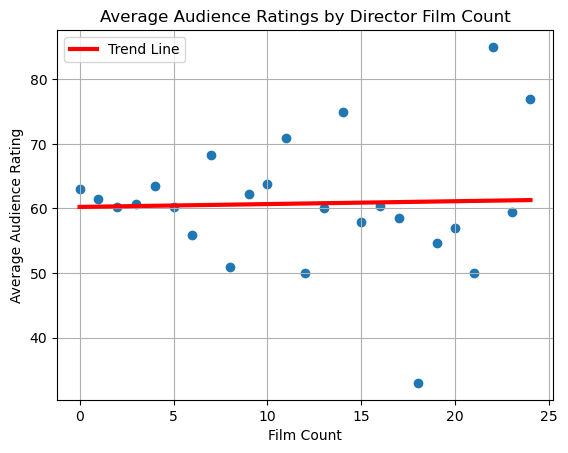

In [52]:
# scatter plot of film count
plt.scatter(data_clean['director_film_count'].unique(), data_clean.groupby('director_film_count')['audience_rating'].mean())
plt.title('Average Audience Ratings by Director Film Count')
plt.ylabel('Average Audience Rating')
plt.xlabel('Film Count')

# calculate best fit linear line
z = np.polyfit(data_clean['director_film_count'].unique(), data_clean.groupby('director_film_count')['audience_rating'].mean(), 1) 
p = np.poly1d(z)

# plot the line of best fit
plt.plot(np.sort(data_clean['director_film_count'].unique()), 
         p(np.sort(data_clean['director_film_count'].unique())), color='red', linewidth=3, label='Trend Line')

# display
plt.legend()
plt.grid()
plt.show()

**Findings**: There is a 'weak' relationsip between these two variables, but one still exists. It might be useful to include this in our models, but including bins might be more fruitful

In [53]:
data_clean['director_experience'] = pd.cut(
    data_clean['director_film_count'],
    bins=[-1, 3, 10, 100],
    labels=['New', 'Moderate', 'Veteran']
)

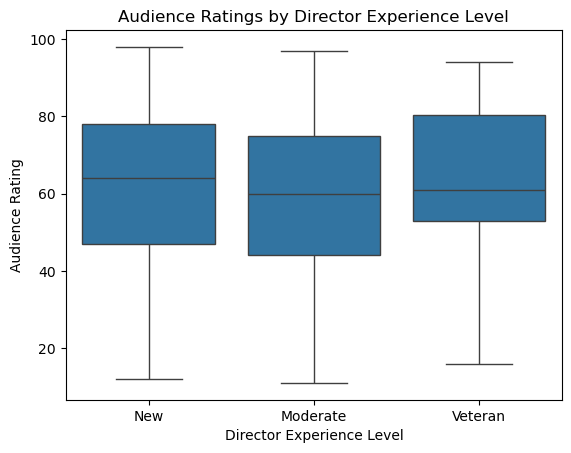

In [54]:
sns.boxplot(x='director_experience', y='audience_rating', data=data_clean)
plt.title("Audience Ratings by Director Experience Level")
plt.xlabel("Director Experience Level")
plt.ylabel("Audience Rating")
plt.show()

**Findings**: Binning the data shows that veteran directors seem to perform at a more consistent level as their range of values is smaller.

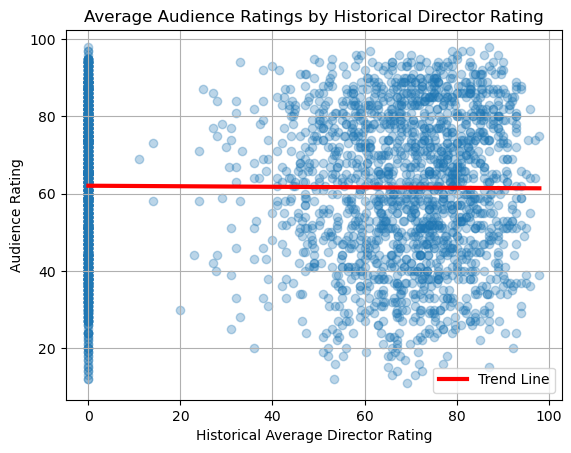

In [55]:
# get neccessary columns for graphing
x = data_clean['director_avg_rating']
y = data_clean['audience_rating']

# fitting a linear equation of the scatter plot
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# plotting the scatter plot and trend line
plt.scatter(x, y, alpha=0.3)
plt.plot(np.sort(x), p(np.sort(x)), color='red', linewidth=3, label='Trend Line')

# plot specifications
plt.title('Average Audience Ratings by Historical Director Rating')
plt.xlabel('Historical Average Director Rating')
plt.ylabel('Audience Rating')
plt.legend()
plt.grid()
plt.show()

**Findings**: Based on the above graph there is no clear evidence that the historical director rating has any influence on movie ratings. In an attempt to still analyze any effect this will be included in the initial model and feature importance will determine if it is valuable.

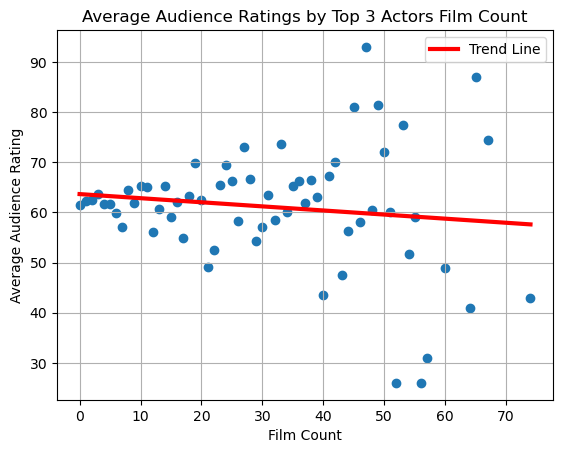

In [56]:
# scatter plot of film count
plt.scatter(data_clean['Top 3 Total Films'].unique(), data_clean.groupby('Top 3 Total Films')['audience_rating'].mean())
plt.title('Average Audience Ratings by Top 3 Actors Film Count')
plt.ylabel('Average Audience Rating')
plt.xlabel('Film Count')

# calculate best fit linear line
z = np.polyfit(data_clean['Top 3 Total Films'].unique(), data_clean.groupby('Top 3 Total Films')['audience_rating'].mean(), 1) 
p = np.poly1d(z)

# plot the line of best fit
plt.plot(np.sort(data_clean['Top 3 Total Films'].unique()), 
         p(np.sort(data_clean['Top 3 Total Films'].unique())), color='red', linewidth=3, label='Trend Line')

# display
plt.legend()
plt.grid()
plt.show()

**Findings**: Theres a weak negative relationship between the film counts, given the high variance in this it might be more important to introduce a bucket variable instead.

In [57]:
data_clean['Actor Experience Level'] = pd.cut(
    data_clean['Top 3 Total Films'], 
    bins=[-1,5,20,100],
    labels=['New','Moderate','Veteran']
)

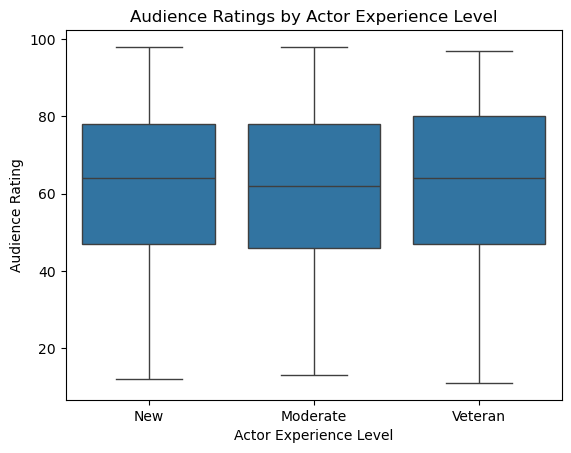

In [58]:
sns.boxplot(x='Actor Experience Level', y='audience_rating', data=data_clean)
plt.title("Audience Ratings by Actor Experience Level")
plt.xlabel("Actor Experience Level")
plt.ylabel("Audience Rating")
plt.show()

**Findings**: This shows a clear relationship between the audience ratings and the actors experience level. This relationship makes sense as actors who are more seasoned and veteran end up getting 'audience fatigue' and new actors are more interesting to audiences.

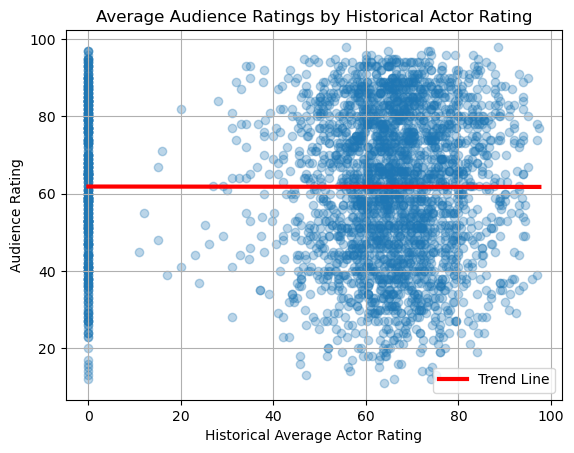

In [59]:
# get neccessary columns for graphing
x = data_clean['Top 3 Average Actor Ratings']
y = data_clean['audience_rating']

# fitting a linear equation of the scatter plot
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# plotting the scatter plot and trend line
plt.scatter(x, y, alpha=0.3)
plt.plot(np.sort(x), p(np.sort(x)), color='red', linewidth=3, label='Trend Line')

# plot specifications
plt.title('Average Audience Ratings by Historical Actor Rating')
plt.xlabel('Historical Average Actor Rating')
plt.ylabel('Audience Rating')
plt.legend()
plt.grid()
plt.show()

In [60]:
# getting dummy variables for bins
data_clean = pd.get_dummies(data_clean, columns=['Actor Experience Level', 'director_experience'], drop_first=True)

**Findings**: This does not show a significant impact, will be included in the model initially but likely removed for simplicity sake and to reduce noise.

### Final DataFrame for Analysis

In [61]:
# synthesizing data for analysis
data_clean = data_clean.drop(['tomatometer_count', 'audience_count', 'director_key', 'Box Office', 'Earnings',
                              'Release year', 'in_theaters_date', 'Actor 1', 'Actor 2', 'Actor 3', 'orig_index'], axis=1)

In [62]:
data_clean.describe()

,Running time,Budget,Actors Box Office %,Director Box Office %,IMDb score,tomatometer_rating,audience_rating,log budget,log run time,sentiment_score,director_avg_rating,Top 3 Average Actor Ratings,director_film_count,Top 3 Total Films
count,3021.000000,3.021000e+03,3.021000e+03,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000,3021.000000
mean,111.476663,3.768899e+07,3.926220e+09,53.225746,6.489308,54.658060,61.790467,16.796149,4.697007,0.226777,39.693953,56.412812,1.806024,8.567362
std,22.076025,4.160991e+07,1.542206e+11,33.737305,1.040899,27.577319,19.467993,1.357487,0.177962,0.507187,35.922242,25.821307,2.713367,10.068927
min,65.000000,1.500000e+04,0.000000e+00,0.000000,1.600000,0.000000,11.000000,9.615805,4.174387,-0.990100,0.000000,0.000000,0.000000,0.000000
25%,97.000000,1.000000e+07,3.333000e+01,33.330000,5.900000,31.000000,47.000000,16.118096,4.574711,-0.038700,0.000000,53.000000,0.000000,2.000000
50%,107.000000,2.500000e+07,5.714000e+01,50.000000,6.600000,56.000000,63.000000,17.034386,4.672829,0.273200,52.166667,64.000000,1.000000,5.000000
75%,121.000000,5.000000e+07,8.333000e+01,80.000000,7.200000,80.000000,78.000000,17.727534,4.795791,0.690800,73.200000,72.000000,2.000000,12.000000
max,325.000000,3.900000e+08,6.805556e+12,100.000000,9.300000,100.000000,98.000000,19.781657,5.783825,0.981900,98.000000,97.500000,24.000000,74.000000


# Data Analysis

## Analysis Part 1: Rotten Tomatoes vs IMDb
* Answering the question: Which movie critic platform, IMDb or Rotten Tomatoes, provides a more reliable guide for audiences deciding which movie to watch? 

In [63]:
rotten_v_IMDb = data_clean[['tomatometer_rating', 'IMDb score', 'audience_rating']]
rotten_v_IMDb

,tomatometer_rating,IMDb score,audience_rating
0,35,6.3,21.0
1,90,6.5,53.0
2,96,7.7,74.0
3,98,8.2,93.0
4,100,7.8,91.0
...,...,...,...
3016,100,7.8,88.0
3017,33,6.0,51.0
3018,17,6.2,56.0
3019,26,4.8,18.0


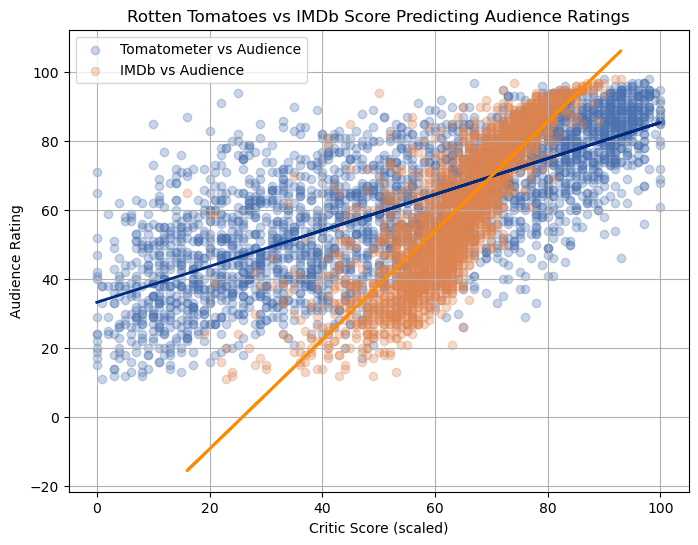

In [64]:
# plotting comparison

plt.figure(figsize=(8,6))

# plotting tomatometer_rating vs audience rating
plt.scatter(rotten_v_IMDb['tomatometer_rating'], rotten_v_IMDb['audience_rating'], alpha=0.3, label='Tomatometer vs Audience', color='#4C72B0')

# plotting IMDb vs audience rating (scaling IMDb to be on the same scoring level
plt.scatter(rotten_v_IMDb['IMDb score']*10, rotten_v_IMDb['audience_rating'], alpha=0.3, label='IMDb vs Audience', color='#DD8452')

# linear trendline for Rotten Tomatoes
z1 = np.polyfit(rotten_v_IMDb['tomatometer_rating'], rotten_v_IMDb['audience_rating'], 1)
p1 = np.poly1d(z1)
plt.plot(rotten_v_IMDb['tomatometer_rating'], p1(rotten_v_IMDb['tomatometer_rating']), linewidth=2, color='#002B7F')

# linear trendline for IMDb
z2 = np.polyfit(rotten_v_IMDb['IMDb score']*10, rotten_v_IMDb['audience_rating'], 1)
p2 = np.poly1d(z2)
plt.plot(rotten_v_IMDb['IMDb score']*10, p2(rotten_v_IMDb['IMDb score']*10), linewidth=2, color='DarkOrange')

# plot specifications
plt.xlabel('Critic Score (scaled)')
plt.ylabel('Audience Rating')
plt.title('Rotten Tomatoes vs IMDb Score Predicting Audience Ratings')
plt.legend()
plt.grid(True)
plt.show()

**Findings**: The IMDb ratings seem to be a more accurate predictors of audience scores, indicated by the steeper linear relationship and the narrowly clustered line. Rotten Tomatoes seems to have high varability with its predictions, but further analysis is necessary to descern differences between these two

In [65]:
# comparison table creator
tom_vs_IMDb_results = {'Website': [],
                       'Model': [],
                    'R2 Score': []}

In [66]:
# Simple Linear Regression Model

# initialize data pipeline
pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('regression', LinearRegression())
])

# initialize kfold
cv = KFold(n_splits=5,
          shuffle=True,
          random_state=20)

# fitting the cv method on the pipeline (rotten tomatoes)
tom_scores_r2 = cross_val_score(estimator=pipe,
                            cv=cv,
                            X=rotten_v_IMDb[['tomatometer_rating']],
                            y=rotten_v_IMDb['audience_rating'],
                            scoring='r2')

tom_scores_mae = cross_val_score(estimator=pipe,
                            cv=cv,
                            X=rotten_v_IMDb[['tomatometer_rating']],
                            y=rotten_v_IMDb['audience_rating'],
                            scoring='neg_mean_absolute_error')

# fitting the cv method on the pipeline (IMDb)
imdb_scores_r2 = cross_val_score(estimator=pipe,
                            cv=cv,
                            X=rotten_v_IMDb[['IMDb score']],
                            y=rotten_v_IMDb['audience_rating'],
                            scoring='r2')

imdb_scores_mae = cross_val_score(estimator=pipe,
                            cv=cv,
                            X=rotten_v_IMDb[['IMDb score']],
                            y=rotten_v_IMDb['audience_rating'],
                            scoring='neg_mean_absolute_error')


In [67]:
# results from simple linear regression model
print('Rotten Tomatoes')
print(f'Average R2: {np.round(np.mean(tom_scores_r2), 3)}')
print(f'Average Mean Squared Error: {-np.round(np.mean(tom_scores_mae), 2)}')
print('\nIMDb')
print(f'Average R2: {np.round(np.mean(imdb_scores_r2), 3)}')
print(f'Average Mean Squared Error: {-np.round(np.mean(imdb_scores_mae), 2)}')

Rotten Tomatoes
Average R2: 0.544
Average Mean Squared Error: 10.51

IMDb
Average R2: 0.714
Average Mean Squared Error: 7.75


**Findings**: Based on the above results it is clear that IMDb does a better job than Rotten Tomatoes at understanding audience enjoyment of movies. A simple model of IMDb alone explains 71.4% of the variance in audience ratings whereas Rotten Tomatoes severly underperforms this measure as only 54.4% of the variance is explained. As expected, the errors that the Rotten Tomatoes model makes are more severe than the IMDb errors, this feature can also be seen visually above as there is a lot more variance in the Rotten Tomatoes datapoints compared to the IMDb datapoints. 

**ANSWER**: IMDb provides audiences with a better guide for their movie watching decisions. Following the ratings of IMDb will generally lead to a better choice for movie fans.

## Analysis Part 2: Baseline Model
* Answering the question: Do movie critic platforms do an accurate job of predicting audience enjoyment? 
* Our baseline model will analyze how well IMDb alone does at predicting audience sentiment on a film

In [68]:
# Necessary Columns for baseline
baseline_df = data_clean[['IMDb score', 'audience_rating']]
baseline_df.head()

,IMDb score,audience_rating
0,6.3,21.0
1,6.5,53.0
2,7.7,74.0
3,8.2,93.0
4,7.8,91.0


In [69]:
baseline_results = {'Model': [],
                    'R2 Score': [],
                   'Parameters': []}

In [70]:
# Simple Linear Regression Model

# initialize data pipeline
pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('regression', LinearRegression())]
    )

# initialize Kfold 
cv = KFold(n_splits=5,
           shuffle=True,
          random_state=20)

# find the strength of the linear regression model
scores = cross_val_score(
    estimator=pipe,
    cv=cv,
    X=baseline_df[['IMDb score']],
    y=baseline_df['audience_rating'],
    scoring='r2'
)

# display the average r2 score of the folds
print(f'Average r2 score from 5-Fold model: {np.round(np.mean(scores), 3)}')

# appending to dictionary
baseline_results['Model'].append('Simple Linear Regression')
baseline_results['R2 Score'].append(np.round(np.mean(scores), 3))
baseline_results['Parameters'].append(None)

Average r2 score from 5-Fold model: 0.714


In [71]:
# testing polynomial regression

# polynomial degree for grid search
params = {'poly__degree': [2,3,4]}

# initialize pipeline
pipe = Pipeline( steps = [
   ('poly', PolynomialFeatures(include_bias=False)),
    ('linear', LinearRegression())]
)

# grid search
grid = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# fit the grid search
grid.fit(baseline_df[['IMDb score']], baseline_df['audience_rating'])

# return the best parameter and score
print(f'Best Score: {grid.best_score_}')
print(f'Best Parameter: {grid.best_params_}')

# appending to dictionary
baseline_results['Model'].append('Polynomial Regression')
baseline_results['R2 Score'].append(np.round(grid.best_score_, 3))
baseline_results['Parameters'].append('Degree = 4')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Score: 0.7683597581468983
Best Parameter: {'poly__degree': 4}


In [72]:
# Decision Tree Model

# max depth for grid search
params = {'max_depth': list(np.arange(1,6,1))}

# initialize Kfold 
cv = KFold(n_splits=5,
           shuffle=True,
          random_state=20)

# initialize grid search
grid = GridSearchCV(
    estimator = DecisionTreeRegressor(random_state=20),
    param_grid = params,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit the grid search
grid.fit(baseline_df[['IMDb score']], baseline_df['audience_rating'])

# return the best parameter and score
print(f'Best Score: {grid.best_score_}')
print(f'Best Parameter: {grid.best_params_}')

# appending to dictionary
baseline_results['Model'].append('Decision Tree')
baseline_results['R2 Score'].append(np.round(grid.best_score_, 3))
baseline_results['Parameters'].append('Max Depth = 5')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.7696335869416067
Best Parameter: {'max_depth': np.int64(5)}


In [73]:
# Random Forest Regressor

# parameters for grid search
params = {'max_depth': [None, 1, 3, 5, 7],
         'n_estimators': list(np.arange(100, 1100, 100))}

# initialize grid search
grid = GridSearchCV(
    estimator = RandomForestRegressor(random_state=20),
    param_grid=params,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit the grid search
grid.fit(baseline_df[['IMDb score']], baseline_df['audience_rating'])

# return the best parameter and score
print(f'Best Score: {grid.best_score_}')
print(f'Best Parameter: {grid.best_params_}')

# appending to dictionary
baseline_results['Model'].append('Random Forest')
baseline_results['R2 Score'].append(np.round(grid.best_score_, 3))
baseline_results['Parameters'].append('Max Depth = 5, Num Estimators = 200')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Score: 0.7714102293416865
Best Parameter: {'max_depth': 5, 'n_estimators': np.int64(600)}


In [74]:
# KNN Regression

# neighbors for grid search
params = {'KNN__n_neighbors': np.arange(1,9, 1)}

# pipeline
pipe = Pipeline(steps = [('scale', StandardScaler()),
                        ('KNN', KNeighborsRegressor())])

# initialize grid search
grid = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit the grid search
grid.fit(baseline_df[['IMDb score']], baseline_df['audience_rating'])

# return the best parameter and score
print(f'Best Score: {grid.best_score_}')
print(f'Best Parameter: {grid.best_params_}')

# appending to dictionary
baseline_results['Model'].append('KNN Regression')
baseline_results['R2 Score'].append(np.round(grid.best_score_, 3))
baseline_results['Parameters'].append('N Neighbors = 8')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score: 0.7472879223435391
Best Parameter: {'KNN__n_neighbors': np.int64(8)}


In [106]:
# testing XG Boost Regression

# params to grid search
params = {'n_estimators': list(np.arange(200, 800, 100)),
         'learning_rate': list(np.arange(0.01, 0.11, 0.01)),
         'max_depth': list(np.arange(1,11, 1))}

# initialize grid search
grid = GridSearchCV(
    estimator=XGBRegressor(random_state=20),
    param_grid=params,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit the grid search
grid.fit(baseline_df[['IMDb score']], baseline_df['audience_rating'])

# return the best parameter and score
print(f'Best Score: {grid.best_score_}')
print(f'Best Parameter: {grid.best_params_}')

# appending to dictionary
baseline_results['Model'].append('XG Boost')
baseline_results['R2 Score'].append(np.round(grid.best_score_, 2))
baseline_results['Parameters'].append('Learning Rate = 0.08, Max Depth = 1, Num Estimators = 200')

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Best Score: 0.7722741897289646
Best Parameter: {'learning_rate': np.float64(0.060000000000000005), 'max_depth': np.int64(1), 'n_estimators': np.int64(600)}


In [104]:
# Results DataFrame
baseline_results_df = pd.DataFrame(baseline_results)

In [105]:
baseline_results_df

,Model,R2 Score,Parameters
0,Simple Linear Regression,0.714,None
1,Polynomial Regression,0.768,Degree = 4
2,Decision Tree,0.770,Max Depth = 5
3,Random Forest,0.771,"Max Depth = 5, Num Estimators = 200"
4,KNN Regression,0.747,N Neighbors = 8
5,XG Boost,0.770,"Learning Rate = 0.08, Max Depth = 1, Num Estim..."
6,XG Boost,0.772,"Learning Rate = 0.08, Max Depth = 1, Num Estim..."


**ANSWER**: IMDb seems to have a generally strong understanding of audience enjoyments of films. This is demonstrated by the baseline R2 of .77, meaning the rating platform alone explain 77% of the variation of audience enjoyment.

**Findings**: The best model for predicting the audience ratings is the XG Boost model. This model explains around 77% of the variation compared to peer reviewed published models it is performing well already. An R2 of .77 means that 77% of the datasets entire variance is being explained by IMDb ratings alone. With the goal of optimizing this model even further, feature engineering will be put in place in order to attempt and create the best possible model

In [96]:
# building final XG Boost model

# splitting the data 
X_train, X_test, y_train, y_test = train_test_split(baseline_df[['IMDb score']],
                                                    baseline_df['audience_rating'], random_state=20, test_size=0.3)

# initializing 
rf = RandomForestRegressor(max_depth=5, n_estimators=200)

# fitting the model
rf.fit(X_train, y_train)

# predicting
y_pred = rf.predict(X_test)

# metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [97]:
# metrics display
print(f'R2: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

R2: 0.7778594161711585
MSE: 82.43575663580206
RMSE: 9.079413892746716


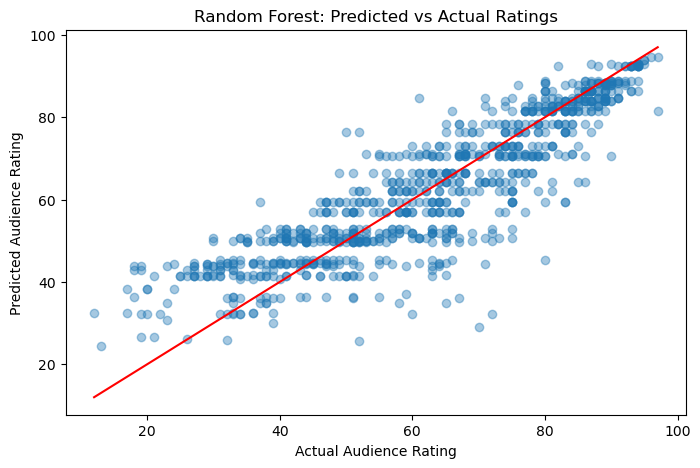

In [99]:
# visualization of predicted vs Actual reatings
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Audience Rating")
plt.ylabel("Predicted Audience Rating")
plt.title("Random Forest: Predicted vs Actual Ratings")
# create a diagonal line through the data
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red')
plt.show()

## Analysis Part 3: In-Depth Model Creation
* Answering Question: Which factors have historically influenced an audience's enjoyment of a movie?   

* Answering Question: How can understanding these factors help future audiences make more informed movie watching decisions? 

In [81]:
in_depth_results = {'Model': [],
                    'R2 Score': [],
                   'Parameters': []}

In [82]:
# Simple Linear Regression Model

# initialize data pipeline
pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('regression', LinearRegression())]
    )

# initialize Kfold 
cv = KFold(n_splits=5,
           shuffle=True,
          random_state=20)

# find the strength of the linear regression model
scores = cross_val_score(
    estimator=pipe,
    cv=cv,
    X=data_clean.drop('audience_rating', axis=1), 
    y=data_clean['audience_rating'],
    scoring='r2'
)

# display the average r2 score of the folds
print(f'Average r2 score from 5-Fold model: {np.round(np.mean(scores), 3)}')

# appending to dictionary
in_depth_results['Model'].append('Simple Linear Regression')
in_depth_results['R2 Score'].append(np.round(np.mean(scores), 3))
in_depth_results['Parameters'].append(None)

Average r2 score from 5-Fold model: 0.747


In [101]:
# trying ridge regression
X = data_clean.drop('audience_rating', axis=1)
y = data_clean['audience_rating']

# pipeline: scale → polynomial features → ridge regression
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('ridge', Ridge())
])

# grid params
params = {
    'poly__degree': [2],
    'ridge__alpha': [0.1, 1, 10]  # regularization strength
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# fit the model
grid.fit(X, y)

# display the best score and parameters
print(f'Best Score: {grid.best_score_:.3f}')
print(f'Best Parameters: {grid.best_params_}')

# append to your dictionary
in_depth_results['Model'].append('Polynomial Ridge Regression')
in_depth_results['R2 Score'].append(np.round(grid.best_score_, 3))

best_deg = grid.best_params_['poly__degree']
best_alpha = grid.best_params_['ridge__alpha']
in_depth_results['Parameters'].append(f'Degree = {best_deg}, Alpha = {best_alpha}')


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Score: 0.632
Best Parameters: {'poly__degree': 2, 'ridge__alpha': 10}


In [84]:
# testing decision tree

# max depth for grid search
params = {'max_depth': list(np.arange(1,6,1))}

# initialize Kfold 
cv = KFold(n_splits=5,
           shuffle=True,
          random_state=20)

# initialize grid search
grid = GridSearchCV(
    estimator = DecisionTreeRegressor(random_state=20),
    param_grid = params,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit the model
grid.fit(data_clean.drop('audience_rating', axis=1), data_clean['audience_rating'])

# display the best score and params
print(f'Best Score: {grid.best_score_}')
print(f'Best Parameters: {grid.best_params_}')

# appending to dictionary
in_depth_results['Model'].append('Decision Tree')
in_depth_results['R2 Score'].append(np.round(grid.best_score_, 3))
in_depth_results['Parameters'].append('Max Depth = 4')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.768847610309922
Best Parameters: {'max_depth': np.int64(4)}


In [85]:
# testing random forest regressor

# parameters for grid search
params = {'max_depth':[None, 1, 3, 5, 7],
         'n_estimators': list(np.arange(100, 1100, 100))}

# initialize grid search
grid = GridSearchCV(
    estimator = RandomForestRegressor(random_state=20),
    param_grid=params,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit the model
grid.fit(data_clean.drop('audience_rating', axis=1), data_clean['audience_rating'])

# display the best score and params
print(f'Best Score: {grid.best_score_}')
print(f'Best Parameters: {grid.best_params_}')

# appending to dictionary
in_depth_results['Model'].append('Random Forest')
in_depth_results['R2 Score'].append(np.round(grid.best_score_, 3))
in_depth_results['Parameters'].append('Max Depth = None, N Estimators = 700')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Score: 0.7975863194437732
Best Parameters: {'max_depth': None, 'n_estimators': np.int64(700)}


In [86]:
# KNN Regression

# neighbors for grid search
params = {'KNN__n_neighbors': np.arange(1,9, 1)}

# pipeline
pipe = Pipeline(steps = [('scale', StandardScaler()),
                        ('KNN', KNeighborsRegressor())])

# initialize grid search
grid = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit the model
grid.fit(data_clean.drop('audience_rating', axis=1), data_clean['audience_rating'])

# display the best score and params
print(f'Best Score: {grid.best_score_}')
print(f'Best Parameters: {grid.best_params_}')

# appending to dictionary
in_depth_results['Model'].append('KNN Regression')
in_depth_results['R2 Score'].append(np.round(grid.best_score_, 3))
in_depth_results['Parameters'].append('N Neighbors = 8')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score: 0.47221144990579367
Best Parameters: {'KNN__n_neighbors': np.int64(8)}


In [87]:
# narrow down the XGB search radius
xgb = XGBRegressor(
    random_state=20
)

param_dist = {
    'n_estimators': np.arange(200, 1601, 100),
    'learning_rate': np.linspace(0.01, 0.2, 20),
    'max_depth': np.arange(3, 11),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_lambda': [0, 1, 5, 10],
    'reg_alpha': [0, 0.1, 0.5, 1]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,          
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

X = data_clean.drop('audience_rating', axis=1)
y = data_clean['audience_rating']

random_search.fit(X, y)

print("Best R²:", random_search.best_score_)
print("Best params:", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best R²: 0.8014692389070589
Best params: {'subsample': np.float64(0.7), 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': np.int64(300), 'min_child_weight': 3, 'max_depth': np.int64(7), 'learning_rate': np.float64(0.03), 'gamma': 0.1, 'colsample_bytree': np.float64(0.9)}


In [108]:
# testing XG Boost Regression

xgb_refined = XGBRegressor(
    random_state=20,
    tree_method="hist",
    min_child_weight=3,
    gamma=0.1,
    reg_lambda=5,
    reg_alpha=1
)

# Only fine-tune the most influential knobs around the best point
param_grid = {
    'n_estimators':    [250, 300, 350],      # center around 300
    'learning_rate':   [0.02, 0.03, 0.04],   # center around 0.03
    'max_depth':       [6, 7, 8],            # center around 7
    'subsample':       [0.6, 0.7],           # around 0.7
    'colsample_bytree':[0.8, 0.9]            # around 0.9
}

# initialize grid search
grid = GridSearchCV(
    estimator=xgb_refined,
    param_grid=param_grid,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# fit the model
grid.fit(data_clean.drop('audience_rating', axis=1), data_clean['audience_rating'])

# display the best score and params
print(f'Best Score: {grid.best_score_}')
print(f'Best Parameters: {grid.best_params_}')

# appending to dictionary
in_depth_results['Model'].append('XG Boost')
in_depth_results['R2 Score'].append(np.round(grid.best_score_, 3))
in_depth_results['Parameters'].append('gamma=0.1, learning_rate=.02, max_depth=6, n_estimators=350, reg_alpha=1, reg_lambda=5, subsample=0.7, min_child_weight=3, colsample_bytree=0., random_state=20')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Score: 0.8032656708384616
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 350, 'subsample': 0.7}


In [89]:
# create a dataframe of the results
final_model_df = pd.DataFrame(in_depth_results)
final_model_df

,Model,R2 Score,Parameters
0,Simple Linear Regression,0.747,None
1,Polynomial Ridge Regression,0.632,"Degree = 2, Alpha = 10.0"
2,Decision Tree,0.769,Max Depth = 4
3,Random Forest,0.798,"Max Depth = None, N Estimators = 1000"
4,KNN Regression,0.472,N Neighbors = 8
5,XG Boost,0.800,"gamma=0, learning_rate=.015, max_depth=6, n_es..."


**Findings**: The best model developed using our data engineered features was the XG Boost model which an R2 of .894. This compares strongly against the best models developed that even include post-release performance metrics like the earnings of a film. Considering we are using solely pre-release metrics to measure something as subjective as audience enjoyment of a film I would say the model is successful.

In [90]:
# building final XG Boost model

# splitting the data 
X_train, X_test, y_train, y_test = train_test_split(data_clean.drop('audience_rating', axis=1),
                                                    data_clean['audience_rating'], random_state=14, test_size=0.3)

# initializing 
xgb= XGBRegressor(
    random_state=20,
    tree_method="hist",
    min_child_weight=3,
    gamma=0.1,
    reg_lambda=5,
    reg_alpha=1,
    colsample_bytree = 0.9,
    learning_rate = 0.02,
    max_depth = 6,
    n_estimators = 350, 
    subsample=0.7
)

# fitting the model
xgb.fit(X_train, y_train)

# predicting
y_pred = xgb.predict(X_test)

# metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [91]:
# metrics display
print(f'R2: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

R2: 0.821107617558583
MSE: 71.61086800735573
RMSE: 8.46232048597521


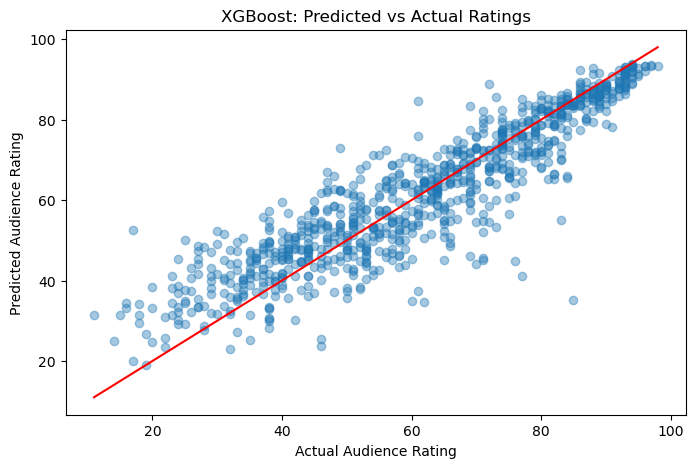

In [92]:
# visualization of predicted vs Actual reatings
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Audience Rating")
plt.ylabel("Predicted Audience Rating")
plt.title("XGBoost: Predicted vs Actual Ratings")
# create a diagonal line through the data
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red')
plt.show()

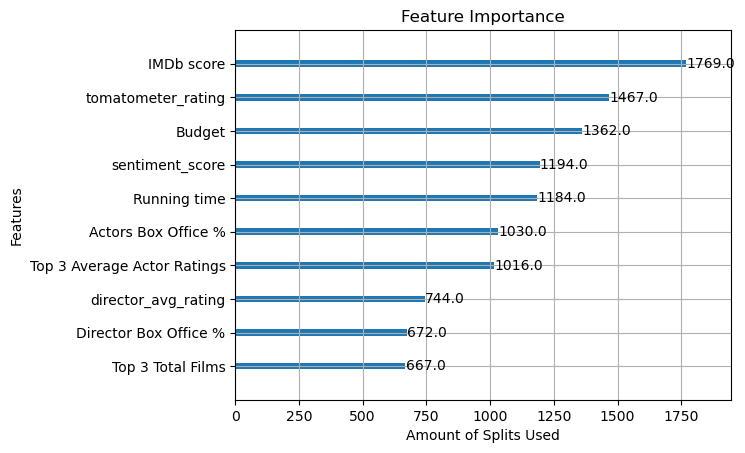

In [93]:
# importance plot (visualizing the most important features)
plot_importance(xgb, max_num_features=10, xlabel='Amount of Splits Used')
plt.title('Feature Importance')
plt.show()

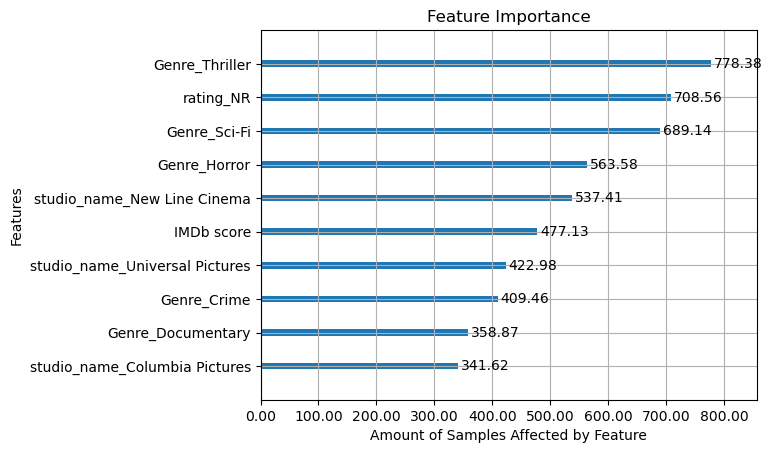

In [94]:
# create axis
ax = plot_importance(
    xgb,
    importance_type='cover',
    max_num_features=10,
    xlabel='Amount of Samples Affected by Feature'
)

# round x-axis tick labels
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))

# remove the original text labels that xgboost added
for txt in ax.texts:
    txt.set_text('')

# add our own rounded labels
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 5,                         
        p.get_y() + p.get_height() / 2,
        f'{width:.2f}',
        va='center'
    )

plt.title("Feature Importance")
plt.show()


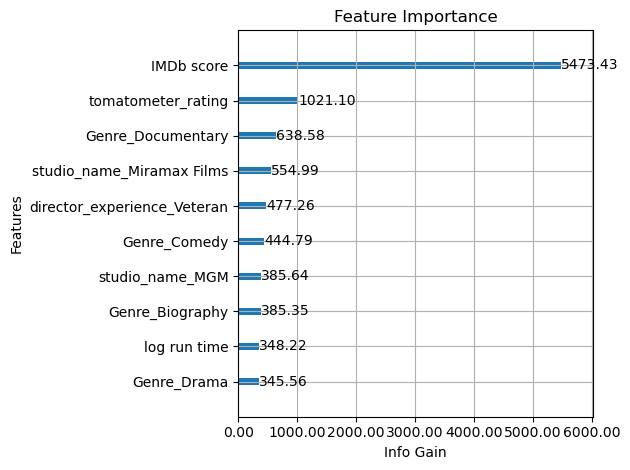

In [95]:
# create axis
ax = plot_importance(
    xgb,
    importance_type='gain',
    max_num_features=10,
    xlabel='Info Gain'
)

# round x-axis tick labels
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))

# remove the original text labels that xgboost added
for txt in ax.texts:
    txt.set_text('')

# add our own rounded labels
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 5,                         
        p.get_y() + p.get_height() / 2,
        f'{width:.2f}',
        va='center'
    )

plt.title("Feature Importance")
plt.tight_layout()
plt.show()


**Findings**: Based on the two above visualizations and the final models R2 of .82 shows that the data engineering improved the model efficency significantly. Given the already strong model of .78 based solely off of IMDb scores and improvement of .04 is significant. The most important feature was clearly IMDb score, which was expected given the strength of the baseline IMDb model. Following that the Genre was massively important as well as the director experience with factors like the amount of films they were in and the ratings of their previous films. It is clear again that Rotten Tomatoes underperforms. Based on the amount of splits that the feature was used in, the running time was extremely significant in splitting the data, followed by the budget and the critic textual sentiment. 